In [2]:
!pip install imblearn

     |████████████████████████████████| 206 kB 43.9 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import time

# Classifiers
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix
from imblearn.pipeline import make_pipeline

from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN

%matplotlib inline

In [2]:
import os 
os.chdir("../")
bucket = 'aws-project-politomaster-sagemaker-data' 

In [3]:
prep_train_path = os.path.join('s3://', bucket, 'preprocess/prep_train.csv')
prep_train = pd.read_csv(prep_train_path)
print("Prep_train dataset has: {} rows and {} columns".format(prep_train.shape[0], prep_train.shape[1]))
prep_train.head()

Prep_train dataset has: 43170 rows and 10 columns


,carat_class,cut,color,clarity,depth,table,price,x,y,z
0,0,4,5,1,61.746807,54.834605,651.357414,5.350743,4.352193,2.667488
1,0,3,5,2,60.811398,60.300733,651.357414,5.350743,4.352193,2.667488
2,0,1,5,4,59.799569,60.300733,651.357414,5.350743,4.352193,2.667488
3,0,3,1,3,62.110048,57.770527,651.357414,5.350743,4.352193,2.667488
4,0,1,0,1,63.367713,58.202601,651.357414,5.350743,4.352193,2.899670


In [4]:
prep_test_path = os.path.join('s3://', bucket, 'preprocess/prep_test.csv')
prep_test = pd.read_csv(prep_test_path)
print("Prep_test dataset has: {} rows and {} columns".format(prep_test.shape[0], prep_test.shape[1]))
prep_train.head()

Prep_test dataset has: 10770 rows and 10 columns


,carat_class,cut,color,clarity,depth,table,price,x,y,z
0,0,4,5,1,61.746807,54.834605,651.357414,5.350743,4.352193,2.667488
1,0,3,5,2,60.811398,60.300733,651.357414,5.350743,4.352193,2.667488
2,0,1,5,4,59.799569,60.300733,651.357414,5.350743,4.352193,2.667488
3,0,3,1,3,62.110048,57.770527,651.357414,5.350743,4.352193,2.667488
4,0,1,0,1,63.367713,58.202601,651.357414,5.350743,4.352193,2.899670


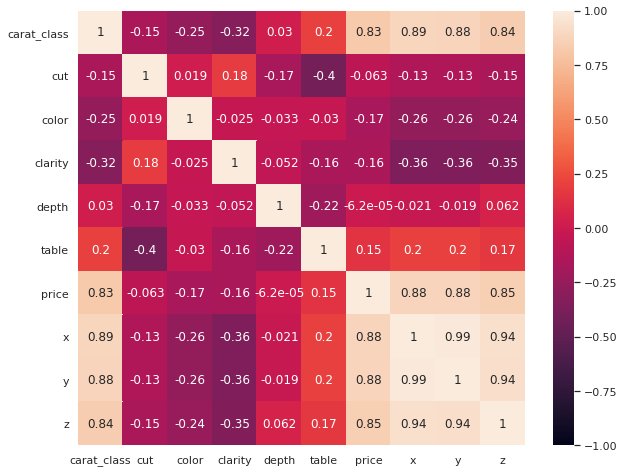

In [5]:
sns.set(rc={'figure.figsize':(10,8)})
fig, ax = plt.subplots(1, 1)
sns.heatmap(prep_train.corr(), vmin = -1, vmax= 1 , annot = True)
#plt.savefig("images/trainingCorr.png")
plt.show()

In [6]:
def categorize_x(x):
    to_return = None
    if x < 7:
        to_return = "low"
    elif x < 9:
        to_return = "medium"
    else:
        to_return = "high"
    return to_return

def categorize_y(y):
    to_return = None
    if y < 6:
        to_return = "low"
    elif y < 8:
        to_return = "medium"
    else:
        to_return = "high"
    return to_return

In [7]:
from sklearn.base import BaseEstimator,TransformerMixin

class CustomTransformer(BaseEstimator,TransformerMixin):
    #def __init__(self):
     #   print('')
        
    def fit(self,X,y=None):
        #print('\n>>>>>>>fit() called.\n')
        return self
    
    def transform(self,X,y=None):
        #print('\n>>>>>>>transform() called.\n')
        X_ = X.copy()

        X_['x_cat'] = X_['x'].apply(lambda x : categorize_x(x)).astype(pd.CategoricalDtype(categories=['low','medium','high'], ordered=True)).cat.codes
        X_['y_cat'] = X_['y'].apply(lambda y : categorize_y(y)).astype(pd.CategoricalDtype(categories=['low','medium','high'], ordered=True)).cat.codes
        
        return X_
        

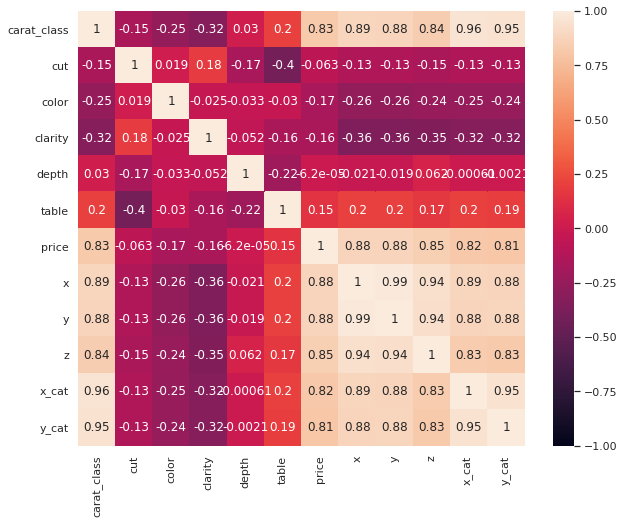

In [8]:
custom_transf = CustomTransformer()
new_train = custom_transf.transform(prep_train)

sns.set(rc={'figure.figsize':(10,8)})
fig, ax = plt.subplots(1, 1)
sns.heatmap(new_train.corr(), vmin = -1, vmax= 1 , annot = True)
#plt.savefig("images/trainingCorr.png")
plt.show()

In [9]:
seed = 0

target = prep_train['carat_class']
data = prep_train.drop(labels = ['carat_class'],axis = 1)
sample_train, sample_val, label_train, label_val = \
    train_test_split(data, target, test_size=0.3, random_state=seed)

In [10]:
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

In [11]:
custom_transf = CustomTransformer()
std_scale = StandardScaler()
pca = PCA(n_components=8)
enn = EditedNearestNeighbours()
#model_pipe = make_pipeline(custom_transf,std_scale,pca,enn)
def get_models():
    models = dict()
    models['knn'] = KNeighborsClassifier()
    models['cart'] = DecisionTreeClassifier()
    models['svm'] = SVC(gamma='auto',kernel='rbf', C = 1.0, random_state = seed)
    return models

def get_models():
    models = dict()
    models['knn'] = KNeighborsClassifier()
    models['cart'] = DecisionTreeClassifier()
    models['svm'] = SVC(gamma='auto',kernel='rbf', C = 1.0, random_state = seed)
    return models

In [12]:
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=seed)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

>knn 0.984 (0.002)
>cart 0.987 (0.002)
>svm 0.986 (0.002)


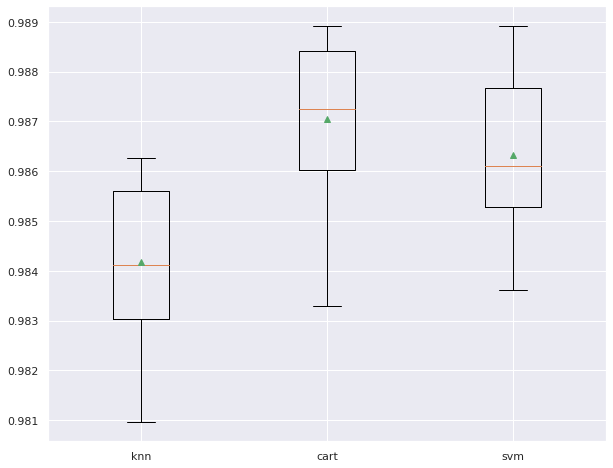

In [13]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()

for name, model in models.items():
    model_pipe = make_pipeline(custom_transf,std_scale,pca,enn,model)
    scores = evaluate_model(model_pipe, sample_train, label_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [14]:
a = 10
a

10

In [15]:
b = 10
b

10

In [25]:
from sklearn.ensemble import StackingClassifier
# get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(KNeighborsClassifier())
    level0.append(DecisionTreeClassifier())
    level0.append(SVC(gamma='auto',kernel='rbf', C = 1.0, random_state = seed))

    # define meta learner model
    level1 = LogisticRegression()
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

In [26]:
def get_models():
    models = dict()
    models['knn'] = KNeighborsClassifier()
    models['cart'] = DecisionTreeClassifier()
    models['svm'] = SVC(gamma='auto',kernel='rbf', C = 1.0, random_state = seed)
    models['stacking'] = get_stacking()
    return models

In [27]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()

for name, model in models.items():
    model_pipe = make_pipeline(custom_transf,std_scale,pca,enn,model)
    scores = evaluate_model(model_pipe, sample_train, label_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()
















>knn 0.984 (0.002)















>cart 0.987 (0.001)















>svm 0.986 (0.002)












TypeError: zip argument #1 must support iteration

>>>>>>>init() called.
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      7602
           1       0.98      0.99      0.99      4785
           2       0.97      0.94      0.95       564

    accuracy                           0.99     12951
   macro avg       0.98      0.97      0.98     12951
weighted avg       0.99      0.99      0.99     12951



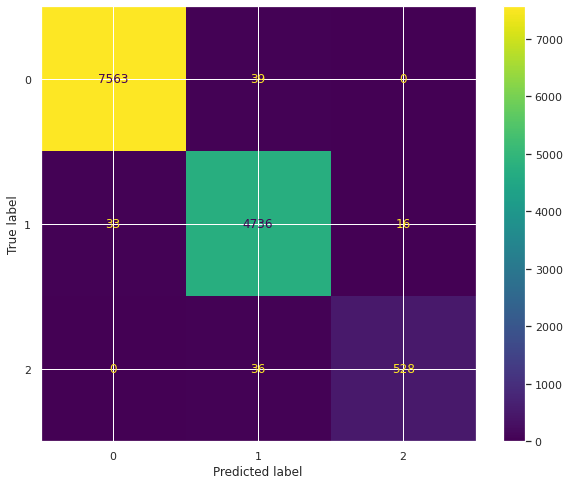

In [17]:
custom_transf = CustomTransformer()
std_scale = StandardScaler()
clf = SVC(gamma='auto',kernel='rbf', C = 1.0, random_state = seed)

model = make_pipeline(custom_transf,std_scale,clf)
model.fit(sample_train, label_train)
pred = model.predict(sample_val)
print(classification_report(label_val,pred))

sns.set(rc={'figure.figsize':(10,8)})
plot_confusion_matrix(model, sample_val, label_val)  
plt.show()

>>>>>>>init() called.
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      7602
           1       0.98      0.99      0.99      4785
           2       0.97      0.92      0.95       564

    accuracy                           0.99     12951
   macro avg       0.98      0.97      0.98     12951
weighted avg       0.99      0.99      0.99     12951



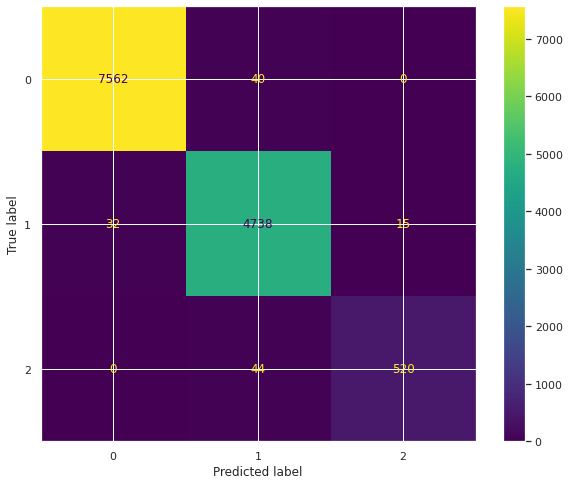

In [18]:
custom_transf = CustomTransformer()
std_scale = StandardScaler()
pca = PCA(n_components=8)
clf = SVC(gamma='auto',kernel='rbf', C = 1.0, random_state = seed)

model = make_pipeline(custom_transf,std_scale,pca,clf)
model.fit(sample_train, label_train)
pred = model.predict(sample_val)
print(classification_report(label_val,pred))
sns.set(rc={'figure.figsize':(10,8)})
plot_confusion_matrix(model, sample_val, label_val)  
plt.show()

>>>>>>>init() called.
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7602
           1       0.98      0.99      0.98      4785
           2       0.97      0.93      0.95       564

    accuracy                           0.99     12951
   macro avg       0.98      0.97      0.97     12951
weighted avg       0.99      0.99      0.99     12951



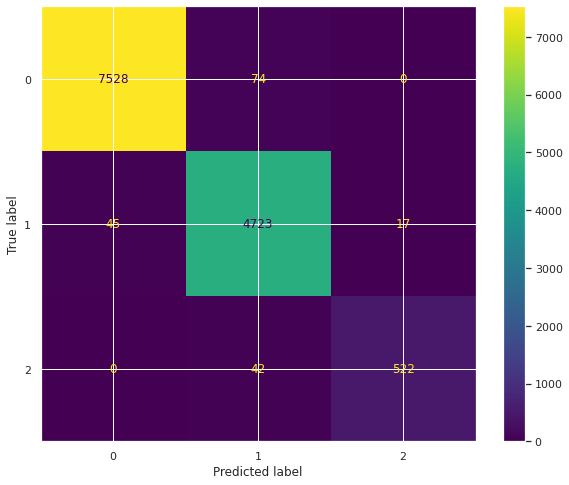

In [19]:
custom_transf = CustomTransformer()
std_scale = StandardScaler()
pca = PCA(n_components=8)
enn = EditedNearestNeighbours()
#rov = RandomOverSampler()
#smote = SMOTE(random_state=0)
#clf = SVC(gamma='auto',kernel='linear', C = 1.0, random_state = seed) #DecisionTreeClassifier() #
clf = SVC(gamma='auto',kernel='rbf', C = 1.0, random_state = seed)

model = make_pipeline(custom_transf,std_scale,pca,enn,clf)
model.fit(sample_train, label_train)
pred = model.predict(sample_val)
print(classification_report(label_val,pred))
sns.set(rc={'figure.figsize':(10,8)})
plot_confusion_matrix(model, sample_val, label_val)  
plt.show()

>>>>>>>init() called.
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      7602
           1       0.98      0.98      0.98      4785
           2       0.91      0.97      0.94       564

    accuracy                           0.99     12951
   macro avg       0.96      0.98      0.97     12951
weighted avg       0.99      0.99      0.99     12951



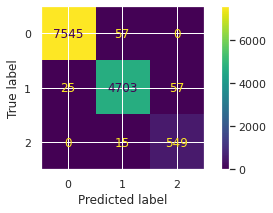

In [20]:
custom_transf = CustomTransformer()
std_scale = StandardScaler()
pca = PCA(n_components=8)
#enn = EditedNearestNeighbours()
#rov = RandomOverSampler()
smote = SMOTE(random_state=seed)
#clf = SVC(gamma='auto',kernel='linear', C = 1.0, random_state = seed) #DecisionTreeClassifier() #
clf = SVC(gamma='auto',kernel='rbf', C = 1.0, random_state = seed)

model = make_pipeline(custom_transf,std_scale,pca,smote,clf)
model.fit(sample_train, label_train)
pred = model.predict(sample_val)
print(classification_report(label_val,pred))
sns.set(rc={'figure.figsize':(6,3)})
plot_confusion_matrix(model, sample_val, label_val)  
plt.show()

>>>>>>>init() called.
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      7602
           1       0.98      0.98      0.98      4785
           2       0.90      0.97      0.94       564

    accuracy                           0.99     12951
   macro avg       0.96      0.98      0.97     12951
weighted avg       0.99      0.99      0.99     12951



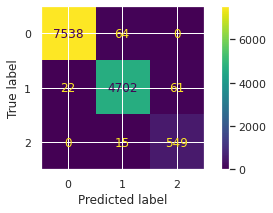

In [22]:
custom_transf = CustomTransformer()
std_scale = StandardScaler()
pca = PCA(n_components=8)
enn = EditedNearestNeighbours()
rov = RandomOverSampler()
smote = SMOTE(random_state=seed)
#clf = SVC(gamma='auto',kernel='linear', C = 1.0, random_state = seed) #DecisionTreeClassifier() #
clf = SVC(gamma='auto',kernel='rbf', C = 1.0, random_state = seed)

model = make_pipeline(custom_transf,std_scale,pca,rov,clf)
model.fit(sample_train, label_train)
pred = model.predict(sample_val)
print(classification_report(label_val,pred))
sns.set(rc={'figure.figsize':(6,3)})
plot_confusion_matrix(model, sample_val, label_val)  
plt.show()

>>>>>>>init() called.
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      7602
           1       0.98      0.98      0.98      4785
           2       0.91      0.98      0.94       564

    accuracy                           0.99     12951
   macro avg       0.96      0.98      0.97     12951
weighted avg       0.99      0.99      0.99     12951



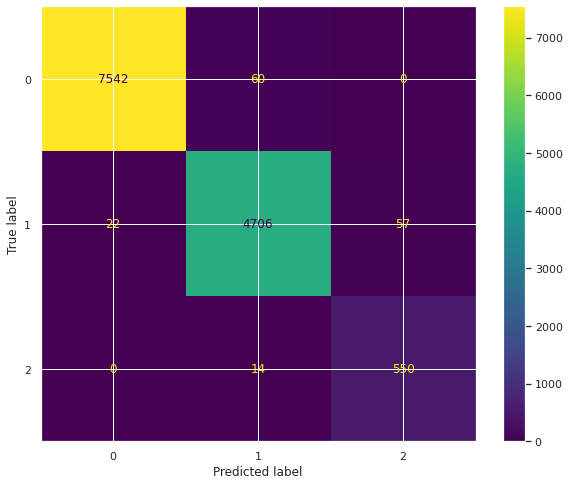

In [23]:
custom_transf = CustomTransformer()
std_scale = StandardScaler()
pca = PCA(n_components=8)
enn = EditedNearestNeighbours()
rov = RandomOverSampler()
smote = SMOTE(random_state=seed)
#clf = SVC(gamma='auto',kernel='linear', C = 1.0, random_state = seed) #DecisionTreeClassifier() #
clf = SVC(gamma='auto',kernel='rbf', C = 1.0, random_state = seed)

model = make_pipeline(custom_transf,std_scale,pca,rov,smote,clf)
model.fit(sample_train, label_train)
pred = model.predict(sample_val)
print(classification_report(label_val,pred))
sns.set(rc={'figure.figsize':(10,8)})
plot_confusion_matrix(model, sample_val, label_val)  
plt.show()

>>>>>>>init() called.
Classifier:  SVC
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      7602
           1       0.98      0.99      0.99      4785
           2       0.97      0.92      0.95       564

    accuracy                           0.99     12951
   macro avg       0.98      0.97      0.98     12951
weighted avg       0.99      0.99      0.99     12951



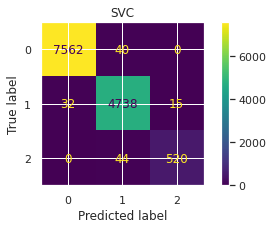

>>>>>>>init() called.
Classifier:  MLPClassifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7602
           1       0.99      0.99      0.99      4785
           2       0.97      0.94      0.95       564

    accuracy                           0.99     12951
   macro avg       0.98      0.97      0.98     12951
weighted avg       0.99      0.99      0.99     12951



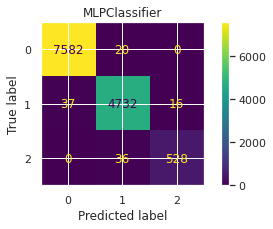

>>>>>>>init() called.
Classifier:  KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7602
           1       0.97      0.99      0.98      4785
           2       0.98      0.88      0.92       564

    accuracy                           0.98     12951
   macro avg       0.98      0.95      0.96     12951
weighted avg       0.98      0.98      0.98     12951



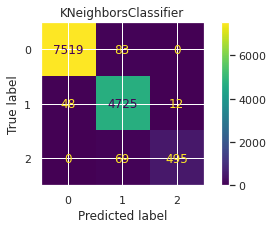

>>>>>>>init() called.
Classifier:  GradientBoostingClassifier
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      7602
           1       0.98      0.99      0.99      4785
           2       0.96      0.95      0.95       564

    accuracy                           0.99     12951
   macro avg       0.98      0.98      0.98     12951
weighted avg       0.99      0.99      0.99     12951



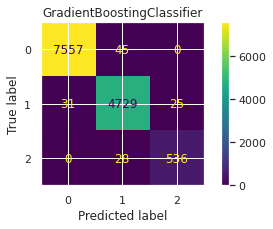

In [24]:
classifiers = [SVC(gamma='auto',kernel='rbf', C = 1.0, random_state = seed),
               MLPClassifier(random_state = seed),
               KNeighborsClassifier(),
               GradientBoostingClassifier(random_state = seed)
]
clf_names = ['SVC','MLPClassifier', 'KNeighborsClassifier', 'GradientBoostingClassifier']

for clf, clf_name in zip(classifiers,clf_names):
    custom_transf = CustomTransformer()
    std_scale = StandardScaler()
    pca = PCA(n_components=8)


    model = make_pipeline(custom_transf,std_scale,pca,clf)
    model.fit(sample_train, label_train)
    pred = model.predict(sample_val)
    print('Classifier: ',clf_name)
    print(classification_report(label_val,pred))
    sns.set(rc={'figure.figsize':(6,3)})
    plot_confusion_matrix(model, sample_val, label_val) 
    plt.title(clf_name)
    plt.show()

>>>>>>>init() called.
Classifier:  SVC
Sampling method:  ENN-Undersample
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7602
           1       0.98      0.99      0.98      4785
           2       0.97      0.93      0.95       564

    accuracy                           0.99     12951
   macro avg       0.98      0.97      0.97     12951
weighted avg       0.99      0.99      0.99     12951



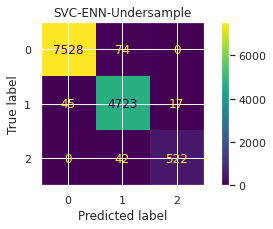

>>>>>>>init() called.
Classifier:  SVC
Sampling method:  ROS-Oversample
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      7602
           1       0.98      0.98      0.98      4785
           2       0.90      0.97      0.94       564

    accuracy                           0.99     12951
   macro avg       0.96      0.98      0.97     12951
weighted avg       0.99      0.99      0.99     12951



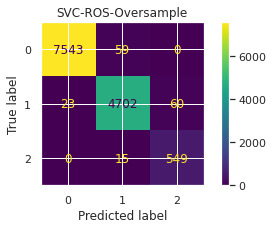

>>>>>>>init() called.
Classifier:  SVC
Sampling method:  SMOTE
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      7602
           1       0.98      0.98      0.98      4785
           2       0.91      0.97      0.94       564

    accuracy                           0.99     12951
   macro avg       0.96      0.98      0.97     12951
weighted avg       0.99      0.99      0.99     12951



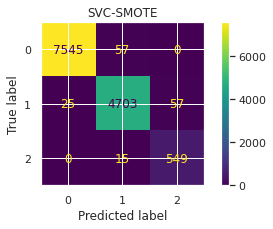

>>>>>>>init() called.
Classifier:  SVC
Sampling method:  ADASYN
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      7602
           1       0.97      0.97      0.97      4785
           2       0.81      0.98      0.89       564

    accuracy                           0.98     12951
   macro avg       0.93      0.98      0.95     12951
weighted avg       0.98      0.98      0.98     12951



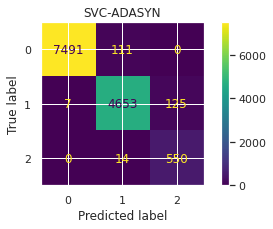

>>>>>>>init() called.
Classifier:  MLPClassifier
Sampling method:  ENN-Undersample
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7602
           1       0.98      0.99      0.98      4785
           2       0.97      0.95      0.96       564

    accuracy                           0.99     12951
   macro avg       0.98      0.98      0.98     12951
weighted avg       0.99      0.99      0.99     12951



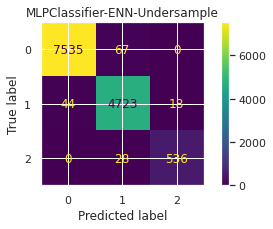

>>>>>>>init() called.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier:  MLPClassifier
Sampling method:  ROS-Oversample
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      7602
           1       0.99      0.99      0.99      4785
           2       0.95      0.97      0.96       564

    accuracy                           0.99     12951
   macro avg       0.98      0.98      0.98     12951
weighted avg       0.99      0.99      0.99     12951



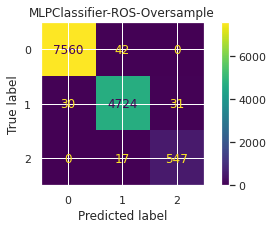

>>>>>>>init() called.
Classifier:  MLPClassifier
Sampling method:  SMOTE
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7602
           1       0.99      0.98      0.99      4785
           2       0.92      0.97      0.94       564

    accuracy                           0.99     12951
   macro avg       0.97      0.98      0.98     12951
weighted avg       0.99      0.99      0.99     12951



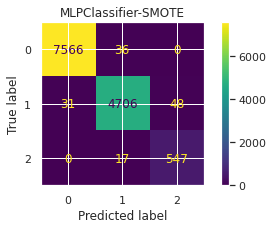

>>>>>>>init() called.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifier:  MLPClassifier
Sampling method:  ADASYN
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      7602
           1       0.98      0.98      0.98      4785
           2       0.92      0.96      0.94       564

    accuracy                           0.99     12951
   macro avg       0.97      0.98      0.97     12951
weighted avg       0.99      0.99      0.99     12951



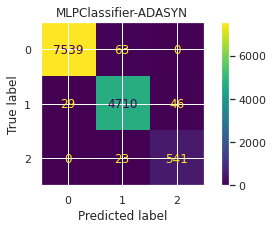

>>>>>>>init() called.
Classifier:  KNeighborsClassifier
Sampling method:  ENN-Undersample
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7602
           1       0.97      0.99      0.98      4785
           2       0.97      0.88      0.92       564

    accuracy                           0.98     12951
   macro avg       0.98      0.95      0.96     12951
weighted avg       0.98      0.98      0.98     12951



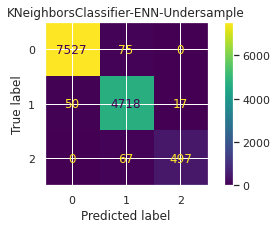

>>>>>>>init() called.
Classifier:  KNeighborsClassifier
Sampling method:  ROS-Oversample
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7602
           1       0.97      0.98      0.98      4785
           2       0.91      0.93      0.92       564

    accuracy                           0.98     12951
   macro avg       0.96      0.96      0.96     12951
weighted avg       0.98      0.98      0.98     12951



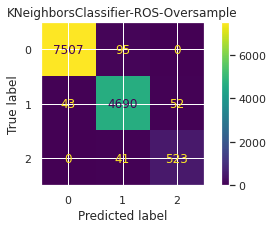

>>>>>>>init() called.
Classifier:  KNeighborsClassifier
Sampling method:  SMOTE
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7602
           1       0.97      0.98      0.97      4785
           2       0.88      0.94      0.91       564

    accuracy                           0.98     12951
   macro avg       0.95      0.97      0.96     12951
weighted avg       0.98      0.98      0.98     12951



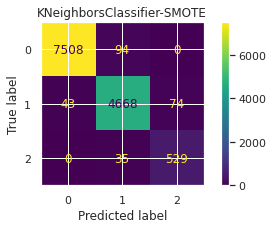

>>>>>>>init() called.
Classifier:  KNeighborsClassifier
Sampling method:  ADASYN
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      7602
           1       0.96      0.98      0.97      4785
           2       0.86      0.93      0.90       564

    accuracy                           0.98     12951
   macro avg       0.94      0.96      0.95     12951
weighted avg       0.98      0.98      0.98     12951



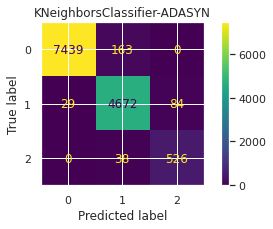

>>>>>>>init() called.
Classifier:  GradientBoostingClassifier
Sampling method:  ENN-Undersample
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7602
           1       0.98      0.98      0.98      4785
           2       0.94      0.96      0.95       564

    accuracy                           0.99     12951
   macro avg       0.97      0.98      0.97     12951
weighted avg       0.99      0.99      0.99     12951



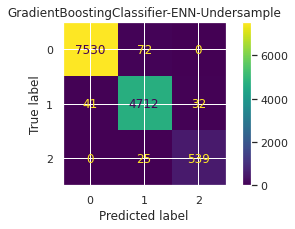

>>>>>>>init() called.
Classifier:  GradientBoostingClassifier
Sampling method:  ROS-Oversample
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      7602
           1       0.99      0.99      0.99      4785
           2       0.94      0.98      0.95       564

    accuracy                           0.99     12951
   macro avg       0.97      0.98      0.98     12951
weighted avg       0.99      0.99      0.99     12951



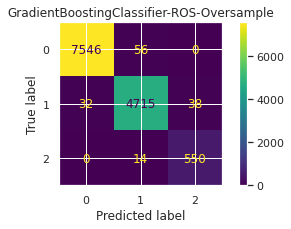

>>>>>>>init() called.
Classifier:  GradientBoostingClassifier
Sampling method:  SMOTE
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      7602
           1       0.99      0.98      0.98      4785
           2       0.92      0.97      0.94       564

    accuracy                           0.99     12951
   macro avg       0.97      0.98      0.97     12951
weighted avg       0.99      0.99      0.99     12951



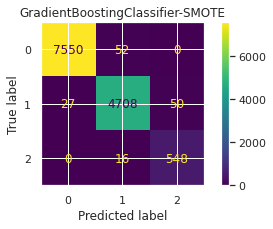

>>>>>>>init() called.
Classifier:  GradientBoostingClassifier
Sampling method:  ADASYN
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      7602
           1       0.98      0.97      0.97      4785
           2       0.80      0.99      0.88       564

    accuracy                           0.98     12951
   macro avg       0.92      0.98      0.95     12951
weighted avg       0.98      0.98      0.98     12951



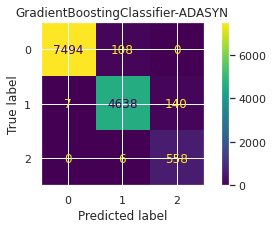

In [25]:
sampling_techs = [EditedNearestNeighbours(), RandomOverSampler(), SMOTE(random_state=seed),ADASYN()]
sampling_names = ['ENN-Undersample', 'ROS-Oversample','SMOTE', 'ADASYN']

for clf, clf_name in zip(classifiers,clf_names):
    for samp, samp_name in zip(sampling_techs,sampling_names):
        custom_transf = CustomTransformer()
        std_scale = StandardScaler()
        pca = PCA(n_components=8)
        
        t0 = time.time()
        model = make_pipeline(custom_transf,std_scale,pca,samp,clf)
        model.fit(sample_train, label_train)
        pred = model.predict(sample_val)
        t1 = time.time()
        print('Classifier: ',clf_name)
        print('Sampling method: ',samp_name)
        print('Time required: ',t1-t0)
        print(classification_report(label_val,pred))
        sns.set(rc={'figure.figsize':(6,3)})
        plot_confusion_matrix(model, sample_val, label_val) 
        plt.title(clf_name + '-'+samp_name)
        plt.show()
    

In [ ]:
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import make_pipeline

custom_transf = CustomTransformer()
std_scale = StandardScaler()
pca = PCA(n_components=8)

pipeline = Pipeline([
    ('samp', EditedNearestNeighbours()),
    ('mlpc', MLPClassifier()),
])

parameters = [
    {
        'samp': ( RandomOverSampler(),),
        'mlpc__hidden_layer_sizes': (100, 200, 500),
        'mlpc__learning_rate':np.array(['constant','adaptive'])
    }
]

t0 = time.time()
grid_search = GridSearchCV(pipeline, parameters)

model = make_pipeline(custom_transf,std_scale, pca, grid_search)
model.fit(sample_train, label_train)
pred = model.predict(sample_val)
t1 = time.time()
print('Time required: ',t1-t0)
print(classification_report(label_val,pred))
sns.set(rc={'figure.figsize':(6,3)})
plot_confusion_matrix(model, sample_val, label_val) 
plt.show()

>>>>>>>init() called.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum

In [ ]:
custom_transf = CustomTransformer()
std_scale = StandardScaler()
pca = PCA(n_components=8)

pipeline = Pipeline([
    ('samp', EditedNearestNeighbours()),
    ('mlpc', MLPClassifier()),
])

parameters = [
    {
        'samp': (EditedNearestNeighbours(),),
        'samp__n_neighbors' : (3,10,100),
        'mlpc__hidden_layer_sizes': [100, 200, 500],
        'mlpc__learning_rate':np.array(['constant','adaptive'])
    }
]


grid_search = GridSearchCV(pipeline, parameters)

model = make_pipeline(custom_transf,std_scale, pca, grid_search)
model.fit(sample_train, label_train)
pred = model.predict(sample_val)
print(classification_report(label_val,pred))
sns.set(rc={'figure.figsize':(6,3)})
plot_confusion_matrix(model, sample_val, label_val) 
plt.show()

In [ ]:
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import make_pipeline

custom_transf = CustomTransformer()
std_scale = StandardScaler()
pca = PCA(n_components=8)

"""
pipeline = Pipeline([
    ('mlpc', MLPClassifier()),
    ('gbtc',GradientBoostingClassifier()),
    ('enn', EditedNearestNeighbours()),
    ('ros', RandomOverSampler()),
    ('smote',SMOTE())
])

parameters = [
    {
        'mlpc__hidden_layer_sizes': (100, 200, 500),
        'mlpc__learning_rate':('adaptive'),
        'gbtc__n_estimators' : (100,200,300),
        'enn__n_neighbors' : (3,10,100),
        'smote__k_neighbors':(5,10,100)
    }
]
"""
pipeline = Pipeline([
    ('samp', EditedNearestNeighbours()),
    ('mlpc', MLPClassifier()),
])

parameters = [
    {
        'samp': (EditedNearestNeighbours(),),
        'samp__n_neighbors' : (3,10,100),
        'mlpc__hidden_layer_sizes': [100, 200, 500],
        'mlpc__learning_rate':np.array(['adaptive'])
    },{
        'samp': ( RandomOverSampler(),),
        'mlpc__hidden_layer_sizes': (100, 200, 500),
        'mlpc__learning_rate':np.array(['adaptive'])
    },{
        'samp': ( SMOTE(),),
        'samp__k_neighbors':(5,10,100),
        'mlpc__hidden_layer_sizes': (100, 200, 500),
        'mlpc__learning_rate':np.array(['adaptive'])
    }
]


grid_search = GridSearchCV(pipeline, parameters)

model = make_pipeline(custom_transf,std_scale, pca, grid_search)
model.fit(sample_train, label_train)
#model.score(sample_train, label_train)

"""
pred = model.predict(sample_val)
print('Classifier: ',clf_name)
print('Sampling method: ',samp_name)
print(classification_report(label_val,pred))
sns.set(rc={'figure.figsize':(6,3)})
plot_confusion_matrix(model, sample_val, label_val) 
plt.title(clf_name + '-'+samp_name)
plt.show()
"""

>>>>>>>init() called.


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum

In [ ]:
pred = model.predict(sample_val)
print(classification_report(label_val,pred))
sns.set(rc={'figure.figsize':(6,3)})
plot_confusion_matrix(model, sample_val, label_val) 
plt.show()

In [ ]:
custom_transf = CustomTransformer()
std_scale = StandardScaler()
pca = PCA(n_components=8)

"""
pipeline = Pipeline([
    ('mlpc', MLPClassifier()),
    ('gbtc',GradientBoostingClassifier()),
    ('enn', EditedNearestNeighbours()),
    ('ros', RandomOverSampler()),
    ('smote',SMOTE())
])

parameters = [
    {
        'mlpc__hidden_layer_sizes': (100, 200, 500),
        'mlpc__learning_rate':('adaptive'),
        'gbtc__n_estimators' : (100,200,300),
        'enn__n_neighbors' : (3,10,100),
        'smote__k_neighbors':(5,10,100)
    }
]
"""
pipeline = Pipeline([
    ('samp', EditedNearestNeighbours()),
    ('clf', MLPClassifier()),
])

parameters = [
    {
        'samp': (EditedNearestNeighbours(),),
        'samp__n_neighbors' : (3,10,100),
        'clf__hidden_layer_sizes': [100, 200, 500],
        'clf__learning_rate':np.array(['adaptive'])
    },{
        'samp': ( RandomOverSampler(),),
        'clf__hidden_layer_sizes': [100, 200, 500],
        'clf__learning_rate':np.array(['adaptive'])
    },{
        'samp': ( SMOTE(),),
        'samp__k_neighbors':(5,10,100),
        'clf__hidden_layer_sizes': [100, 200, 500],
        'clf__learning_rate':np.array(['adaptive'])
    },{
        'samp': (EditedNearestNeighbours(),),
        'samp__n_neighbors' : (3,10,100),
        'clf':(GradientBoostingClassifier(),),
        'clf__n_estimators' : [100,200,300],
    },{
        'samp': ( RandomOverSampler(),),
        'clf':(GradientBoostingClassifier(),),
        'clf__n_estimators' : [100,200,300],
    },{
        'samp': ( SMOTE(),),
        'samp__k_neighbors':(5,10,100),
        'clf':(GradientBoostingClassifier(),),
        'clf__n_estimators' : [100,200,300],
    }
]

pred = model.predict(sample_val)
print(classification_report(label_val,pred))
sns.set(rc={'figure.figsize':(6,3)})
plot_confusion_matrix(model, sample_val, label_val) 
plt.show()
